# Лабораторная работа 4: Градиентный бустинг

**Набор данных**: [Human Activity Recognition Using Smartphones](http://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones)

**Цель**: Реализовать градиентный бустинг с обоснованием выбора гиперпараметров, посчитать метрики качества (accuracy, precision, recall, F1-меру) и вывести ROC-кривую.

---

<a name="data-loading"></a>
## 1. Загрузка и предобработка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import urllib.request
# import zipfile
# import os

# dataset_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip'
# urllib.request.urlretrieve(dataset_url, 'UCI_HAR_Dataset.zip')

# with zipfile.ZipFile('UCI_HAR_Dataset.zip', 'r') as zip_ref:
#     zip_ref.extractall('UCI_HAR_Dataset')

In [2]:
X_train = pd.read_csv('UCI HAR Dataset/train/X_train.txt', delim_whitespace=True, header=None)
y_train = pd.read_csv('UCI HAR Dataset/train/y_train.txt', delim_whitespace=True, header=None)

X_test = pd.read_csv('UCI HAR Dataset/test/X_test.txt', delim_whitespace=True, header=None)
y_test = pd.read_csv('UCI HAR Dataset/test/y_test.txt', delim_whitespace=True, header=None)

### Предобработка данных

Для упрощения задачи сконцентрируемся на бинарной классификации, выбрав две активности: `1` (Walking) и `2` (Walking Upstairs).

In [3]:
# Фильтрация данных для классов 1 и 2
binary_classes = [1, 2]
train_filter = y_train[0].isin(binary_classes)
test_filter = y_test[0].isin(binary_classes)

X_train_binary = X_train[train_filter.values]
y_train_binary = y_train[train_filter.values]
X_test_binary = X_test[test_filter.values]
y_test_binary = y_test[test_filter.values]

# Преобразование меток в 0 и 1
y_train_binary = y_train_binary[0].map({1: 0, 2: 1}).values
y_test_binary = y_test_binary[0].map({1: 0, 2: 1}).values

# Преобразование данных в numpy массивы
X_train_binary = X_train_binary.values
X_test_binary = X_test_binary.values

---

<a name="gradient-boosting"></a>
## 2. Реализация градиентного бустинга

<a name="decision-stump"></a>
### 2.1. Классификатор Decision Stump

Реализуем простой решающий пень (Decision Stump), который будет использоваться в качестве базового алгоритма в градиентном бустинге.

In [4]:
class DecisionStumpRegressor:
    def __init__(self):
        self.feature_index = None
        self.threshold = None
        self.left_value = None
        self.right_value = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        min_error = float('inf')

        # Перебор всех признаков
        for feature_i in range(n_features):
            feature_values = X[:, feature_i]
            thresholds = np.unique(feature_values)
            # Перебор всех возможных порогов
            for threshold in thresholds:
                left_indices = feature_values < threshold
                right_indices = feature_values >= threshold

                # Вычисление средних значений для левого и правого узлов
                left_mean = np.mean(y[left_indices]) if np.sum(left_indices) > 0 else 0
                right_mean = np.mean(y[right_indices]) if np.sum(right_indices) > 0 else 0

                # Вычисление ошибки
                predictions = np.zeros(n_samples)
                predictions[left_indices] = left_mean
                predictions[right_indices] = right_mean
                error = np.mean((y - predictions) ** 2)

                if error < min_error:
                    min_error = error
                    self.threshold = threshold
                    self.feature_index = feature_i
                    self.left_value = left_mean
                    self.right_value = right_mean

    def predict(self, X):
        n_samples = X.shape[0]
        feature_values = X[:, self.feature_index]
        predictions = np.zeros(n_samples)
        left_indices = feature_values < self.threshold
        right_indices = feature_values >= self.threshold
        predictions[left_indices] = self.left_value
        predictions[right_indices] = self.right_value
        return predictions

<a name="gb-classifier"></a>
### 2.2. Классификатор Gradient Boosting

Реализуем градиентный бустинг для бинарной классификации с использованием логистической функции потерь.

In [5]:
class GradientBoostingClassifier:
    def __init__(self, n_estimators=10, learning_rate=0.1):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.base_learners = []

    def fit(self, X, y):
        # Инициализация прогнозов
        y_pred = np.full(y.shape, np.log(np.sum(y == 1) / np.sum(y == 0)))

        for i in range(self.n_estimators):
            # Вычисление негативного градиента (остатков)
            residual = y - self._sigmoid(y_pred)

            # Обучение базового алгоритма на остатках
            stump = DecisionStumpRegressor()
            stump.fit(X, residual)

            # Обновление прогнозов
            y_pred += self.learning_rate * stump.predict(X)

            # Сохранение базового алгоритма
            self.base_learners.append(stump)

    def predict_proba(self, X):
        y_pred = np.zeros(X.shape[0])
        for stump in self.base_learners:
            y_pred += self.learning_rate * stump.predict(X)
        proba = self._sigmoid(y_pred)
        return proba

    def predict(self, X):
        proba = self.predict_proba(X)
        return (proba >= 0.5).astype(int)

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

---

<a name="hyperparameters"></a>
## 3. Обоснование выбора гиперпараметров

- **Количество базовых алгоритмов (n_estimators = 10)**: Выбрано для баланса между качеством модели и временем обучения. Большее число базовых алгоритмов может привести к переобучению и увеличению времени обучения.
- **Скорость обучения (learning_rate = 0.1)**: Малое значение скорости обучения позволяет модели учиться более плавно и избегать переобучения.

---

<a name="training"></a>
## 4. Обучение модели

In [6]:
gb_clf = GradientBoostingClassifier(n_estimators=10, learning_rate=0.1)
gb_clf.fit(X_train_binary, y_train_binary)

---

<a name="evaluation"></a>
## 5. Оценка модели

Реализуем функции для расчета метрик качества без использования scikit-learn.

In [7]:
def accuracy_score(y_true, y_pred):
    return np.mean(y_true == y_pred)

def precision_score(y_true, y_pred):
    true_positive = np.sum((y_true == 1) & (y_pred == 1))
    predicted_positive = np.sum(y_pred == 1)
    return true_positive / predicted_positive if predicted_positive > 0 else 0

def recall_score(y_true, y_pred):
    true_positive = np.sum((y_true == 1) & (y_pred == 1))
    actual_positive = np.sum(y_true == 1)
    return true_positive / actual_positive if actual_positive > 0 else 0

def f1_score(y_true, y_pred):
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    return 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0

In [8]:
# Прогноз на тестовых данных
y_pred = gb_clf.predict(X_test_binary)

# Расчет метрик
accuracy = accuracy_score(y_test_binary, y_pred)
precision = precision_score(y_test_binary, y_pred)
recall = recall_score(y_test_binary, y_pred)
f1 = f1_score(y_test_binary, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.8769
Precision: 0.9151
Recall: 0.8238
F1 Score: 0.8670


---

<a name="roc-curve"></a>
## 6. Построение ROC-кривой

In [9]:
def compute_roc_curve(y_true, y_scores):
    thresholds = np.sort(np.unique(y_scores))
    tpr_list = []
    fpr_list = []

    P = np.sum(y_true == 1)
    N = np.sum(y_true == 0)

    for thresh in thresholds:
        y_pred = (y_scores >= thresh).astype(int)
        TP = np.sum((y_true == 1) & (y_pred == 1))
        FP = np.sum((y_true == 0) & (y_pred == 1))
        TPR = TP / P if P > 0 else 0
        FPR = FP / N if N > 0 else 0
        tpr_list.append(TPR)
        fpr_list.append(FPR)

    return fpr_list, tpr_list

def compute_auc(fpr, tpr):
    sorted_indices = np.argsort(fpr)
    fpr = np.array(fpr)[sorted_indices]
    tpr = np.array(tpr)[sorted_indices]
    return np.trapz(tpr, fpr)

In [10]:
# Получение вероятностей
y_scores = gb_clf.predict_proba(X_test_binary)

# Вычисление ROC-кривой
fpr, tpr = compute_roc_curve(y_test_binary, y_scores)

# Вычисление AUC
auc_value = compute_auc(fpr, tpr)
print(f'AUC: {auc_value:.4f}')

AUC: 0.9453


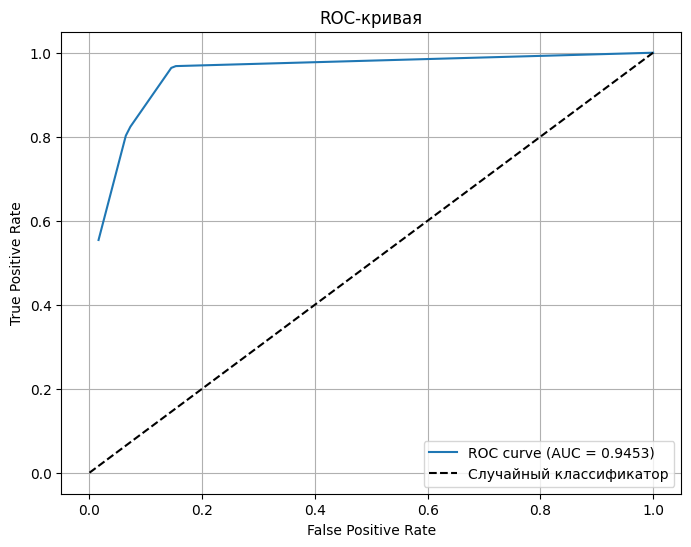

In [11]:
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_value:.4f})')
plt.plot([0,1], [0,1], 'k--', label='Случайный классификатор')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

---

**Вывод**: Мы успешно реализовали градиентный бустинг с использованием простых базовых алгоритмов (Decision Stump) и рассчитали метрики качества модели. ROC-кривая и AUC показывают качество работы модели на тестовых данных.